# Pretraining Powerhouse

We will use all the components we studied in the previous notebooks. Let's Train our gpt ~^^

Out GPT just waits for training and will be ready for inference. So in this notebook, we'll review
- how to prepare text data for GPT training
- how our GPT model can learn and optimize itself
- The training process, including forward and backward passes.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import tiktoken
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import yaml

from src.multiattention import MultiHeadAttention 
from src.transformerblock import TransformerBlock
from src.gpt import ARGPT


In [2]:
!pip install PyYAML

In [3]:
import sys
print(sys.version)

3.9.20 (main, Sep  6 2024, 19:03:56) 
[Clang 16.0.0 (clang-1600.0.26.3)]


In [4]:
import sys
sys.path.append('src')

## 1. Preparing Text Data

Now we will be building the class responsible for preparing the text data. It will tokenize the text file and create overlapping sequences of tokens for our PseudoGPT model to learn from.

Let's say we have this text: `"Hi, are you ready to train your GPT!"`. On  this stage for `class TextDataset` we will need:
1. Tokenizer (we'll stick to `tiktoken` here but feel free to re-use what we have previously built)

After tokenization, it might look something like this (these are made-up token IDs):
[15, 20, 7, 35, 12, 45, 8, 60, 75]

2. Block size definition

It is the length of the sequences that the model will process. It determines how much context the model sees at once. For example, if block_size is 64, the model will work with sequences of 64 tokens at a time.

3. Sliding window approach with overlapping input-output pairs
   
Let's say our block_size is 5. The idea is that given the sequence/chunk [15, 20, 7, 35, 12], the model should predict [20, 7, 35, 12, 45].
This sliding window approach allows the model to learn the relationships between tokens in the text.

In [5]:
# Use your example text
with open('data/your_text_file.txt', 'r') as file:
    text = file.readline().strip()

print("The first line of the file:\n", text)

The first line of the file:
 Hello, Visionaries of AI's Human-Centric Future!


In [6]:
# Tokenize the text
tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(text)

# Set block_size
block_size = 4

# Create a function to get chunks with a sliding window
def get_chunks(idx):
    input_chunk = tokens[idx : idx + block_size]
    target_chunk = tokens[idx + 1 : idx + block_size + 1]
    return input_chunk, target_chunk

In [7]:
# Create a DataFrame to display the results
data = []
for idx in range(len(tokens) - block_size):
    input_chunk, target_chunk = get_chunks(idx)
    input_text = tokenizer.decode(input_chunk)
    target_text = tokenizer.decode(target_chunk)
    data.append({
        'idx': idx,
        'input_chunk': input_chunk,
        'input_text': input_text,
        'target_chunk': target_chunk,
        'target_text': target_text
    })

df = pd.DataFrame(data)

In [8]:
display(df)

print("\nOriginal tokens:")
print(tokens)
print("\nOriginal text:")
print(tokenizer.decode(tokens))

,idx,input_chunk,input_text,target_chunk,target_text
0,0,"[15496, 11, 19009, 3166]","Hello, Visionaries","[11, 19009, 3166, 286]",", Visionaries of"
1,1,"[11, 19009, 3166, 286]",", Visionaries of","[19009, 3166, 286, 9552]",Visionaries of AI
2,2,"[19009, 3166, 286, 9552]",Visionaries of AI,"[3166, 286, 9552, 338]",aries of AI's
3,3,"[3166, 286, 9552, 338]",aries of AI's,"[286, 9552, 338, 5524]",of AI's Human
4,4,"[286, 9552, 338, 5524]",of AI's Human,"[9552, 338, 5524, 12]",AI's Human-
5,5,"[9552, 338, 5524, 12]",AI's Human-,"[338, 5524, 12, 19085]",'s Human-Cent
6,6,"[338, 5524, 12, 19085]",'s Human-Cent,"[5524, 12, 19085, 1173]",Human-Centric
7,7,"[5524, 12, 19085, 1173]",Human-Centric,"[12, 19085, 1173, 10898]",-Centric Future
8,8,"[12, 19085, 1173, 10898]",-Centric Future,"[19085, 1173, 10898, 0]",Centric Future!



Original tokens:
[15496, 11, 19009, 3166, 286, 9552, 338, 5524, 12, 19085, 1173, 10898, 0]

Original text:
Hello, Visionaries of AI's Human-Centric Future!


Now that we can see the input and output chunks, we can also check how our `TextDataset` looks like:

In [9]:
class TextDataset(Dataset):
    def __init__(self, text, block_size, tokenizer):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.data = self.tokenizer.encode(text)

    def __len__(self):
        return len(self.data) - self.block_size

    def get_chunks(self, idx):
        input_chunk = self.data[idx : idx + self.block_size]
        target_chunk = self.data[idx + 1 : idx + self.block_size + 1]
        return input_chunk, target_chunk

    def __getitem__(self, idx):
        input_chunk, target_chunk = self.get_chunks(idx)
        x = torch.tensor(input_chunk, dtype=torch.long)
        y = torch.tensor(target_chunk, dtype=torch.long)
        return x, y

In [10]:
class TextDataset(Dataset):
    def __init__(self, text, block_size, tokenizer, stride=1):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.stride = stride
        self.data = self.tokenizer.encode(text)

    def __len__(self):
        
        return max(0, (len(self.data) - self.block_size) // self.stride + 1)

    def get_chunks(self, idx):

        # Add stride
        input_chunk = self.data[idx + self.stride : idx + self.block_size]
        target_chunk = self.data[idx + 1 + self.stride : idx + self.block_size + 1]
        return input_chunk, target_chunk
     

    def __getitem__(self, idx):
        input_chunk, target_chunk = self.get_chunks(idx)
        
        x = torch.tensor(input_chunk, dtype=torch.long)
        y = torch.tensor(target_chunk, dtype=torch.long)
        return x, y

In [11]:
with open('data/your_text_file.txt', 'r') as file:
    textfile = file.read()

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")
block_size = 6
stride = 2 # You can adjust this value

dataset = TextDataset(textfile, block_size, tokenizer, stride)
dataset[1]

(tensor([3166,  286, 9552,  338]), tensor([ 286, 9552,  338, 5524]))

And now we can review how dataset can turned into DataLoader with certain batches of data.

In [13]:
# recall why we needed to pad sequences from our exercises on tokenization
def collate_fn(batch):
    # Separate the input sequences and targets
    sequences, targets = zip(*batch)
    
    # Pad the sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # Pad the targets if they are sequences, otherwise just stack them
    if isinstance(targets[0], torch.Tensor) and targets[0].dim() > 0:
        padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)
    else:
        padded_targets = torch.stack(targets)
    
    return padded_sequences, padded_targets

In [14]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

In [15]:
for batch in train_dataloader:
    inputs, targets = batch
    print("Input:", inputs)
    print("Target:", targets)
    break

Input: tensor([[  286,  9552,   290, 15119],
        [  286,  3725,    13,  3954],
        [   11, 11409, 11153,    11],
        [ 3183,   286,  3725,    13],
        [  286,  9552,   284,   262],
        [47220,  2314,   307,   625],
        [  290,  4292,  1692, 16389],
        [35016,   278,   511,  9889],
        [  198,   818,   262, 13360],
        [  407,   832, 24005,  9014],
        [   11,   290,  1597,  2766],
        [  389,   973, 43493,   290],
        [ 2478,   284,  8335,   262],
        [ 4329,   517, 11521,   656],
        [16357,  2776,   810,  9552],
        [ 1031,   364, 14582,   284],
        [  198,   464, 19980,   286],
        [  286,  1366,   290,  5911],
        [  286,  5000,   649,  5107],
        [ 5384,   290,  8217,  2251],
        [   13,  3574,  2563,  9412],
        [   11,  2683,   286,  6782],
        [  198,   198,   464, 15028],
        [ 1165,    11,   318,   852],
        [13433,    11,   475,   287],
        [ 2568, 16020,    13,  1081],
     

## 2. Passing Forward and Backward

**Forward Pass** is the step where the input is passed through the model to obtain predictions. It computes the logits or output values.

```python
logits = model(input_sequence)
loss = loss_fn(logits, target_sequence)
````

``logits`` are the raw prediction scores from the model, and ``loss`` is calculated based on the difference between the predicted outputs (``logits``) and the actual targets (``target_sequence``).

Let's say we have a very small vocabulary of 3 words: ["Hi", "GPT", "coder"]
We're training a model to predict the next word given a sequence of words.

Suppose our model predicts probabilities for the next word after "Hello":
- Model output (logits after softmax):
["Hi": 0.1, "GPT": 0.2, "coder": 0.4]
- True next word: "GPT"
- In case of using CrossEntropy function for loss calculation: `loss = -log(probability of correct word)`:

loss = -log(0.2) ≈ 0.699

This loss value tells us how far off our prediction was from the correct answer. Lower loss means better prediction.

In [16]:
logits = torch.tensor([[2.0, 2.5, 3.0]])  # shape: [1, 3]

# True label (index of "LLM")
target = torch.tensor([1])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, target)
print(f"Loss: {loss.item()}")

Loss: 1.180269718170166


In **Backward Pass** step, gradients are computed using the loss from the forward pass. The ``loss.backward()`` function calculates the gradient of the loss with respect to all the learnable parameters in the model.

```python
optimizer.zero_grad()   # Clear previous gradients
loss.backward()         # Compute gradients
optimizer.step()        # Update model parameters
```

Now, let's see how the gradient-descent optimization algorithm, e.g. Adam, would update the model parameters based on this loss.

``model.train()`` sets the model in training mode. It tells the model that it's in training mode, which affects certain layers like dropout and batch normalization that behave differently during training and evaluation.

```python
model.train()
```

``model.eval()`` sets the model in evaluation mode. Dropout will be disabled. When a model is being used to make predictions, batch normalization layers use the mean and variance of the training data  instead of calculating new ones from the input data, making the process more stable and reliable.

```python
model.eval()
```

``torch.no_grad()`` is a context manager used to perform computations without tracking gradients, which reduces memory consumption and speeds up computation when you are not training (e.g., evaluation/inference).

In [17]:
# Simplified tokenization
vocab = ['Hi', 'GPT', 'Coder', 'Are', 'You', 'Ready', '!', '<unk>']
word_to_ix = {word: i for i, word in enumerate(vocab)}
tokens = [word_to_ix.get(word, word_to_ix['<unk>']) for word in text.split()]

# Create input-target pairs
input_sequence = torch.tensor(tokens[:-1])
target_sequence = torch.tensor(tokens[1:])

In [18]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, x):
        return self.linear(self.embedding(x))

model = SimpleLanguageModel(len(vocab), embedding_dim=10)

print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

SimpleLanguageModel(
  (embedding): Embedding(8, 10)
  (linear): Linear(in_features=10, out_features=8, bias=True)
)


In [19]:
for epoch in range(5):
    # Set the model to training mode
    model.train()
    
    # Forward pass
    logits = model(input_sequence)
    loss = loss_fn(logits, target_sequence)
    
    # Backward pass
    optimizer.zero_grad()   # Reset gradients
    loss.backward()         # Compute gradients
    optimizer.step()        # Update model parameters
    
    # Print current state
    print(f"Epoch {epoch}:")
    print(f"  Loss: {loss.item():.4f}")
    
    # Evaluation - do not compute gradients
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(logits[0], dim=0)
        for word, prob in zip(vocab, probs):
            print(f"    {word}: {prob.item():.4f}")

Epoch 0:
  Loss: 2.4532
    Hi: 0.0910
    GPT: 0.1749
    Coder: 0.0844
    Are: 0.0975
    You: 0.1374
    Ready: 0.1754
    !: 0.1534
    <unk>: 0.0860
Epoch 1:
  Loss: 2.2840
    Hi: 0.0901
    GPT: 0.1700
    Coder: 0.0831
    Are: 0.0962
    You: 0.1346
    Ready: 0.1732
    !: 0.1509
    <unk>: 0.1019
Epoch 2:
  Loss: 2.1188
    Hi: 0.0890
    GPT: 0.1648
    Coder: 0.0815
    Are: 0.0946
    You: 0.1314
    Ready: 0.1705
    !: 0.1480
    <unk>: 0.1202
Epoch 3:
  Loss: 1.9578
    Hi: 0.0875
    GPT: 0.1596
    Coder: 0.0797
    Are: 0.0927
    You: 0.1278
    Ready: 0.1670
    !: 0.1446
    <unk>: 0.1412
Epoch 4:
  Loss: 1.8010
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651


In [20]:
def train(model, input_sequence, target_sequence, loss_fn, optimizer):
    #  finalize train()
    
    # 1. Set the model to training mode
    model.train()
    optimizer.zero_grad()   # Reset gradients
    # 2. Pass input_sequence through model 
    output = model(input_sequence)
    # 3. Compare the logits wuth target_sequece using loss function
    loss = loss_fn(output, target_sequence)
    # 4. Run backward pass
    loss.backward()         # Compute gradients
    optimizer.step()        # Update model parameters
    # 5. Return loss.item()
    return loss.item()
    


In [21]:
def evaluate(model, input_sequence, vocab):
    # finalize evaluate()
    
    # 1. Set the model to evaluation mode
    model.eval()
    # 2. Set the computation to be without gradients
    with torch.no_grad():
    # 3. Pass input_sequence through model 
        output = model(input_sequence)
    # 4. Apply softmax along batch dimension for the model output with the first element
        probs = torch.softmax(logits[0], dim=0)
        for word, prob in zip(vocab, probs):
            print(f"    {word}: {prob.item():.4f}")


In [22]:
for epoch in range(5):
    print(f"Epoch {epoch+1}:")
    
    # Train the model
    loss = train(model, input_sequence, target_sequence, loss_fn, optimizer)
    
    # Evaluate the model
    evaluate(model, input_sequence, vocab)

Epoch 1:
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651
Epoch 2:
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651
Epoch 3:
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651
Epoch 4:
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651
Epoch 5:
    Hi: 0.0857
    GPT: 0.1542
    Coder: 0.0776
    Are: 0.0904
    You: 0.1236
    Ready: 0.1626
    !: 0.1407
    <unk>: 0.1651


## 4. Bring It All Together

#### Hyperparameters Explained
Let's review what hyperparameters we have already used and will add to our config file.

- `vocab_size`: The size of the model's vocabulary. Larger vocabularies can capture more nuanced language but require more computational resources.
- `d_model`: Dimension of the model's embeddings and hidden states. Larger values increase model capacity but also computational cost.
- `num_heads`: Number of attention heads in multi-head attention layers. More heads can capture different types of dependencies in the input.
- `num_layers`: Number of transformer blocks in the model. More layers increase model depth and capacity.
- `d_ff`: Dimension of the feed-forward layer in transformer blocks. Larger values increase model capacity.
- `max_seq_length`: Maximum sequence length the model can handle. Longer sequences allow for more context but increase memory usage.
- `dropout`: Dropout rate for regularization. Higher values can prevent overfitting but may slow down training.
- `batch_size`: Number of samples processed in each training step. Larger batches can lead to more stable gradients but require more memory.
- `num_epochs`: Number of times the model will see the entire dataset during training.
- `learning_rate`: Step size at each iteration while moving toward a minimum of the loss function.

In [23]:
%%writefile config.yaml

# Model parameters
vocab_size: 50257  # GPT-2 tokenizer vocabulary size
d_model: 256
num_heads: 8
num_layers: 6
d_ff: 1024
max_seq_length: 128
dropout: 0.1

# Training parameters
batch_size: 64
num_epochs: 1 # we set to a low value
learning_rate: 3e-4


#  use your text file
data_path: "data/your_text_file.txt"

Overwriting config.yaml


In [24]:
# Load the config file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

model = ARGPT(
            vocab_size=config['vocab_size'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            num_layers=config['num_layers'],
            d_ff=config['d_ff'],
            max_seq_length=config['max_seq_length'],
            dropout=config['dropout']
        )

print(model)



ARGPT(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(128, 256)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=256, out_features=50257, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm): LayerNorm((256,),

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

num_params = count_parameters(model)
model_size_mb = estimate_model_size(model)

num_params_millions = num_params / 1e6

print(f"Number of trainable parameters: {num_params_millions:,}M")
print(f"Estimated model size: {model_size_mb:.2f} MB")


# Estimate size for float16 (half precision)
model_size_half_mb = model_size_mb / 2
print(f"Estimated model size (float16): {model_size_half_mb:.2f} MB")



Number of trainable parameters: 30.553681M
Estimated model size: 116.55 MB
Estimated model size (float16): 58.28 MB


In [26]:
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cpu")
        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.num_epochs = config['num_epochs']  

        self.model = ARGPT(
            vocab_size=config['vocab_size'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            num_layers=config['num_layers'],
            d_ff=config['d_ff'],
            max_seq_length=config['max_seq_length'],
            dropout=config['dropout']
        ).to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()

        print(f"Learning rate: {config['learning_rate']}, Type: {type(config['learning_rate'])}")
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=config['learning_rate'])

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
        
        dataset = TextDataset(text, self.config['max_seq_length'], self.tokenizer)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=True, collate_fn=collate_fn)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.config['batch_size'], collate_fn=collate_fn)

    def train(self):
        train_losses = []
        val_losses = []
        
        # Integrate loops around batches for train()
        
        for epoch in range(self.num_epochs):
            self.model.train()
            epoch_loss = 0.0
            
            for batch in self.train_dataloader:
                input_sequence, target_sequence = batch
                print("target shape: ", target_sequence.shape)
                input_sequence = input_sequence.to(self.device)
                target_sequence = target_sequence.to(self.device)
                
                self.optimizer.zero_grad()
                output= self.model(input_sequence)
                print("output shape:", output.shape)
                loss = self.criterion(output.flatten(0, 1), target_sequence.flatten())
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_train_loss = epoch_loss / len(self.train_dataloader)
            train_losses.append(avg_train_loss)
            
            val_loss = self.evaluate()
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses


    def evaluate(self):
        self.model.eval()
        total_loss = 0.0
        
        with torch.no_grad():
            for batch in self.val_dataloader:
                input_sequence, target_sequence = batch
                input_sequence = input_sequence.to(self.device)
                target_sequence = target_sequence.to(self.device)
                
                output = self.model(input_sequence)
                loss = self.criterion(output.flatten(0, 1), target_sequence.flatten())
                total_loss += loss.item()

        return total_loss / len(self.val_dataloader)


    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.savefig('loss_plot.png')
        plt.show()
        plt.close()

    def plot_token_probabilities(self, input_text):
        self.model.eval()
        input_ids = torch.tensor(self.tokenizer.encode(input_text)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids)
        
        probs = torch.softmax(outputs[0, -1], dim=-1)
        top_k = 10
        top_probs, top_indices = torch.topk(probs, top_k)
        
        top_tokens = [self.tokenizer.decode([idx.item()]) for idx in top_indices]
        
        plt.figure(figsize=(12, 6))
        plt.bar(top_tokens, top_probs.cpu().numpy())
        plt.title(f"Top {top_k} Token Probabilities for Next Token")
        plt.xlabel("Tokens")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('token_probabilities.png')
        plt.show()
        plt.close()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

In [27]:
def load_config(config_path):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    config['learning_rate'] = float(config['learning_rate'])
    return config

Learning rate: 0.0003, Type: <class 'float'>
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 50257])
target shape:  torch.Size([64, 127])
output shape: torch.Size([64, 127, 502

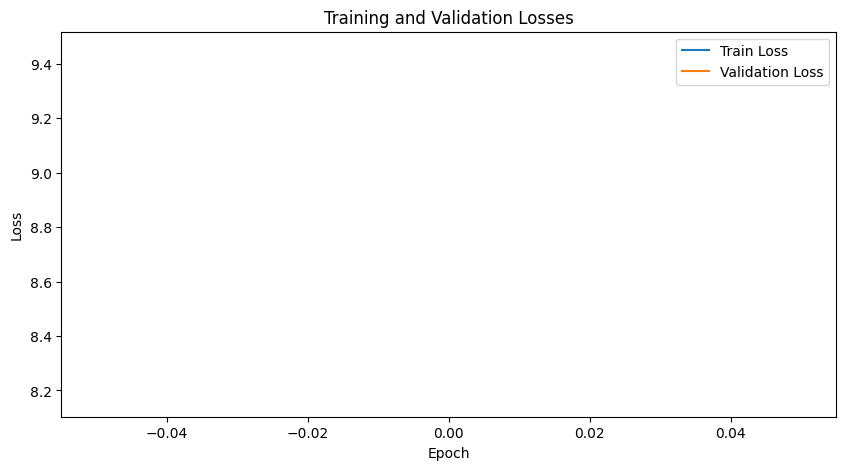

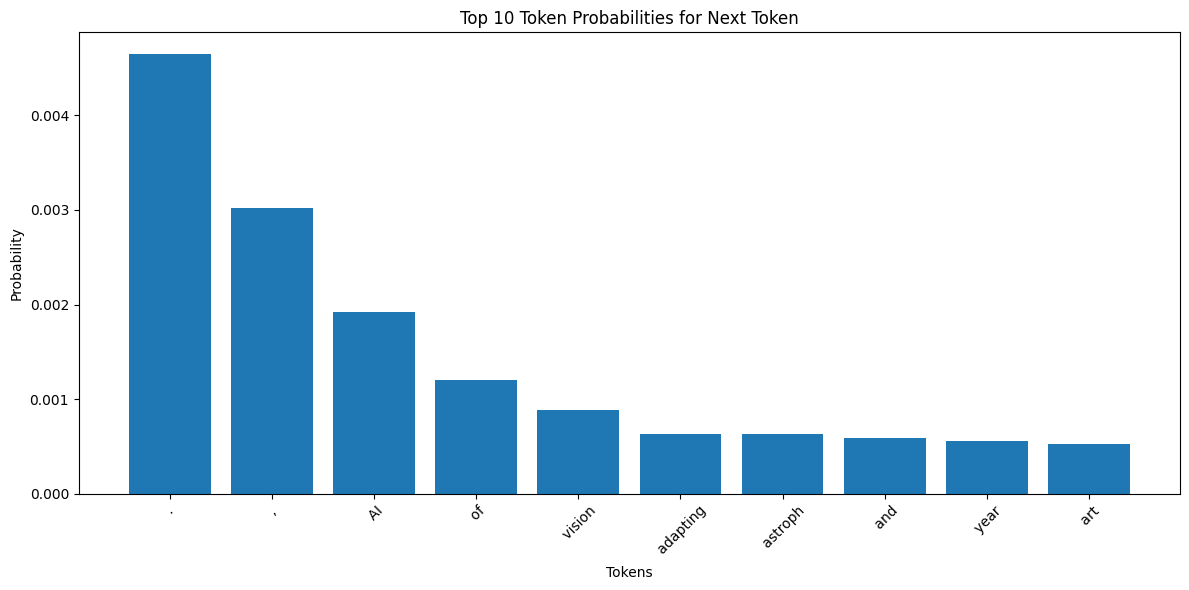

In [28]:
# Think how you would integrate this all into your main.py
config = load_config('config.yaml')
trainer = Trainer(config)
trainer.load_data(config['data_path'])

train_losses, val_losses = trainer.train()
trainer.plot_losses(train_losses, val_losses)

sample_input = "Once upon a time"
trainer.plot_token_probabilities(sample_input)

trainer.save_model("ARgpt_model.pth")

#### Wow, how amazing it is to be on this stage! You've just completed an incredible journey through the world of GPT models.

Let's take a moment to appreciate what you've accomplished:

1. You've built the core components of a GPT model from scratch, including the attention mechanism, transformer blocks, and the overall model structure.
2. You've created an efficient data pipeline that processes text data into a format suitable for training language models.
3. You've implemented and executed the training loop, including forward passes, loss calculation, and backpropagation.

Congratulations, Trailblazer! Now it's time for putting GPT into action with the real problems you want to solve. Where would you like to start?